In [1]:
from matplotlib import pyplot as plt

import numpy as np
import tensorflow as tf

import os
import pandas as pd

from functools import reduce
from datetime import datetime

from ionmob.models.deep_models import ProjectToInitialSqrtCCS, DeepRecurrentModel
from ionmob.preprocess.data import get_tf_dataset, partition_tf_dataset, split_dataset, to_tf_dataset_kmer
from ionmob.preprocess.helpers import get_sqrt_slopes_and_intercepts, sequence_to_tokens, fit_tokenizer
from ionmob.preprocess.helpers import tokenizer_to_json, tokenizer_from_json
from ionmob.preprocess.tokenization import get_index_dict, get_occurring_kmers, create_count_vectors

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

gpus = tf.config.experimental.list_physical_devices('GPU')

In [2]:
meier = pd.read_parquet('../data/Meier.parquet')
tenzer = pd.read_parquet('../data/Tenzer_unique.parquet')
tenzer_phospho = pd.read_parquet('../data/Tenzer-dda-phospho_unique.parquet')
chang = pd.read_parquet('../data/Chang_unique.parquet')

t = pd.concat([meier, tenzer, tenzer_phospho, chang])

all_pairs = get_occurring_kmers(t)
index_dict = get_index_dict(all_pairs)

In [3]:
meier['tuple-counts'] = create_count_vectors(meier, index_dict)
tenzer['tuple-counts'] = create_count_vectors(tenzer, index_dict)
tenzer_phospho['tuple-counts'] = create_count_vectors(tenzer_phospho, index_dict)
chang['tuple-counts'] = create_count_vectors(chang, index_dict)

In [4]:
phos_train, phos_valid, phos_test = split_dataset(tenzer_phospho)
train = pd.concat([meier, phos_train])
valid = pd.concat([tenzer, phos_valid])
test = pd.concat([chang, phos_test])

In [5]:
slopes, intercepts = get_sqrt_slopes_and_intercepts(t.mz.values, t.charge.values, t.ccs.values)

In [6]:
tf_train = to_tf_dataset_kmer(train.mz, train.charge, train['tuple-counts'].values, train.ccs, batch=False)
tf_valid = to_tf_dataset_kmer(valid.mz, valid.charge, valid['tuple-counts'].values, valid.ccs)
tf_test = to_tf_dataset_kmer(test.mz, test.charge, test['tuple-counts'].values, test.ccs)

tf_train = tf_train.shuffle(train.shape[0]).batch(2048)

In [11]:
from ionmob.models.deep_models import KmerNet

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_output_1_loss',
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='training/rnn/checkpoint',
    monitor='val_output_1_loss',
    save_best_only=True,
    mode='min'
)

csv_logger = tf.keras.callbacks.CSVLogger(
    filename='training/rnn/training.csv',
    separator=',',
    append=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_output_1_loss',
    factor=1e-1,
    patience=3,
    monde='auto',
    min_delta=1e-5,
    cooldown=0,
    min_lr=1e-7
)

cbs = [early_stopper, reduce_lr] # checkpoint, csv_logger, tensorboard_callback

model = KmerNet(
    slopes,
    intercepts
)

model.build([(None, 1), (None, 4), (None, len(index_dict))])

model.compile(loss=tf.keras.losses.MeanAbsoluteError(), loss_weights=[1.],
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mae', 'mean_absolute_percentage_error'])

In [12]:
history = model.fit(tf_train, validation_data=tf_valid, 
                    epochs=100, verbose=True, callbacks=cbs)

Epoch 1/100
378/378 [==============================] - 9s 17ms/step - loss: 11.4460 - mae: 11.3522 - mean_absolute_percentage_error: 2.1934 - val_loss: 12.1176 - val_mae: 12.0284 - val_mean_absolute_percentage_error: 2.4606 - lr: 0.0010
Epoch 2/100
378/378 [==============================] - 7s 15ms/step - loss: 11.3158 - mae: 11.2301 - mean_absolute_percentage_error: 2.1679 - val_loss: 12.1421 - val_mae: 12.0598 - val_mean_absolute_percentage_error: 2.4669 - lr: 0.0010
Epoch 3/100
378/378 [==============================] - 7s 15ms/step - loss: 11.3004 - mae: 11.2215 - mean_absolute_percentage_error: 2.1659 - val_loss: 12.0738 - val_mae: 11.9979 - val_mean_absolute_percentage_error: 2.4517 - lr: 0.0010
Epoch 4/100
378/378 [==============================] - 7s 15ms/step - loss: 11.2911 - mae: 11.2182 - mean_absolute_percentage_error: 2.1652 - val_loss: 12.0395 - val_mae: 11.9694 - val_mean_absolute_percentage_error: 2.4464 - lr: 0.0010
Epoch 5/100
378/378 [==============================]

378/378 [==============================] - 7s 15ms/step - loss: 11.2576 - mae: 11.2110 - mean_absolute_percentage_error: 2.1637 - val_loss: 12.0990 - val_mae: 12.0536 - val_mean_absolute_percentage_error: 2.4628 - lr: 0.0010
Epoch 12/100
378/378 [==============================] - 7s 15ms/step - loss: 11.2555 - mae: 11.2112 - mean_absolute_percentage_error: 2.1637 - val_loss: 12.0054 - val_mae: 11.9620 - val_mean_absolute_percentage_error: 2.4426 - lr: 0.0010
Epoch 13/100
378/378 [==============================] - 7s 14ms/step - loss: 11.2520 - mae: 11.2099 - mean_absolute_percentage_error: 2.1635 - val_loss: 12.0490 - val_mae: 12.0080 - val_mean_absolute_percentage_error: 2.4532 - lr: 0.0010
Epoch 14/100
378/378 [==============================] - 7s 14ms/step - loss: 11.2519 - mae: 11.2112 - mean_absolute_percentage_error: 2.1636 - val_loss: 12.0287 - val_mae: 11.9887 - val_mean_absolute_percentage_error: 2.4499 - lr: 0.0010
Epoch 15/100
378/378 [==============================] - 7s 14

378/378 [==============================] - 7s 14ms/step - loss: 11.2408 - mae: 11.2074 - mean_absolute_percentage_error: 2.1629 - val_loss: 11.9964 - val_mae: 11.9639 - val_mean_absolute_percentage_error: 2.4423 - lr: 0.0010
Epoch 22/100
378/378 [==============================] - 7s 15ms/step - loss: 11.2386 - mae: 11.2067 - mean_absolute_percentage_error: 2.1628 - val_loss: 12.0588 - val_mae: 12.0271 - val_mean_absolute_percentage_error: 2.4594 - lr: 0.0010
Epoch 23/100
378/378 [==============================] - 7s 14ms/step - loss: 11.2408 - mae: 11.2084 - mean_absolute_percentage_error: 2.1632 - val_loss: 12.0371 - val_mae: 12.0047 - val_mean_absolute_percentage_error: 2.4523 - lr: 0.0010
Epoch 24/100
378/378 [==============================] - 7s 14ms/step - loss: 11.2410 - mae: 11.2085 - mean_absolute_percentage_error: 2.1631 - val_loss: 12.0291 - val_mae: 11.9970 - val_mean_absolute_percentage_error: 2.4526 - lr: 0.0010
Epoch 25/100
378/378 [==============================] - 7s 14

Epoch 32/100
378/378 [==============================] - 7s 14ms/step - loss: 11.2347 - mae: 11.2063 - mean_absolute_percentage_error: 2.1624 - val_loss: 12.0503 - val_mae: 12.0227 - val_mean_absolute_percentage_error: 2.4586 - lr: 0.0010
Epoch 33/100
378/378 [==============================] - 7s 14ms/step - loss: 11.2348 - mae: 11.2075 - mean_absolute_percentage_error: 2.1629 - val_loss: 12.0103 - val_mae: 11.9835 - val_mean_absolute_percentage_error: 2.4470 - lr: 0.0010
Epoch 34/100
378/378 [==============================] - 7s 15ms/step - loss: 11.2326 - mae: 11.2062 - mean_absolute_percentage_error: 2.1627 - val_loss: 12.0213 - val_mae: 11.9944 - val_mean_absolute_percentage_error: 2.4505 - lr: 0.0010
Epoch 35/100
378/378 [==============================] - 7s 15ms/step - loss: 11.2340 - mae: 11.2073 - mean_absolute_percentage_error: 2.1629 - val_loss: 12.0258 - val_mae: 11.9996 - val_mean_absolute_percentage_error: 2.4517 - lr: 0.0010
Epoch 36/100
378/378 [==========================

378/378 [==============================] - 7s 14ms/step - loss: 11.2330 - mae: 11.2063 - mean_absolute_percentage_error: 2.1627 - val_loss: 12.0663 - val_mae: 12.0388 - val_mean_absolute_percentage_error: 2.4604 - lr: 0.0010
Epoch 43/100
378/378 [==============================] - 7s 14ms/step - loss: 11.2352 - mae: 11.2071 - mean_absolute_percentage_error: 2.1628 - val_loss: 12.0238 - val_mae: 11.9960 - val_mean_absolute_percentage_error: 2.4519 - lr: 0.0010
Epoch 44/100
347/378 [==========================>...] - ETA: 0s - loss: 11.2330 - mae: 11.2062 - mean_absolute_percentage_error: 2.1623

KeyboardInterrupt: 

In [18]:
ccs = model.predict(tf_valid)
valid['ccs_predicted'] = ccs

20/20 [==============================] - 0s 11ms/step


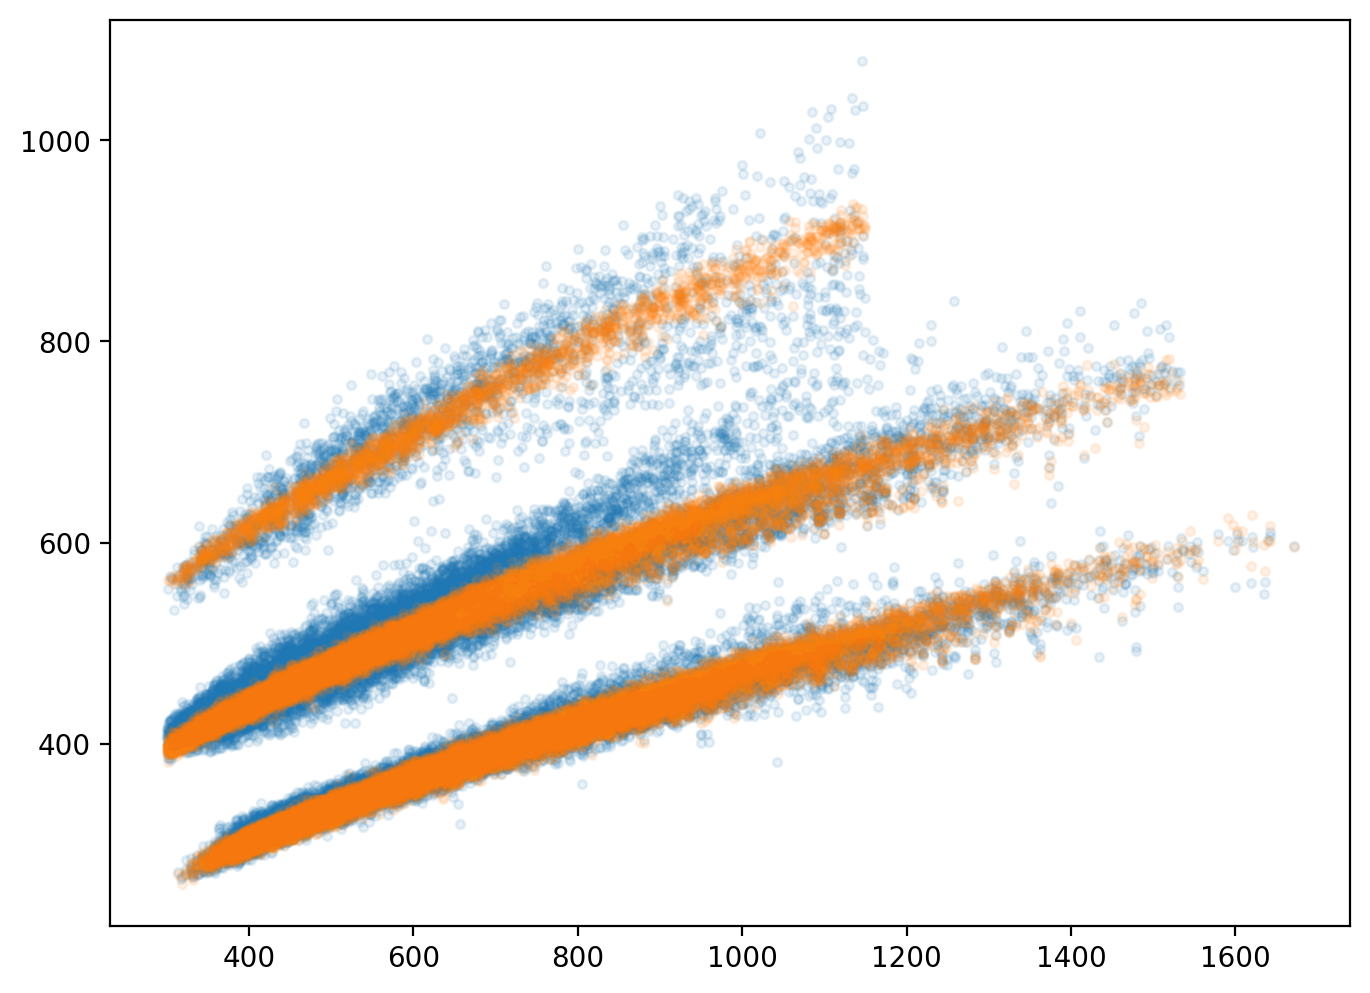

In [22]:
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(valid.mz, valid.ccs, alpha=.1, s=10)
plt.scatter(valid.mz, valid.ccs_predicted, alpha=.1, s=10)
plt.show()

In [ ]:
# plot training and validation loss 
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(history.history['output_1_mae'], label='training')
plt.plot(history.history['val_output_1_mae'], label='validation')
plt.hlines(9.5, xmin=0, xmax=len(history.history['output_1_mae']), linestyles='dashed', color='black', linewidth=1, alpha=.75)
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()